In [1]:
import numpy as np
import pandas as pd
import ast 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from my_utils import save_parameters

In [186]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, f1_score

from xgboost import XGBRegressor

In [3]:
path = "models/Exercice2/models_parameters.csv"

In [4]:
SAVE_RESULTS = False
SEARCH_BEST_PARAMS = False

# PART 1 - Song classification and recommendation

In [5]:
spotify_dataset_subset = pd.read_csv("datasets/dataset_part_1/spotify_dataset_subset.csv")

In [6]:
print(f"Dimensions du jeu de données d'entrainement : {spotify_dataset_subset.shape[0]} lignes et {spotify_dataset_subset.shape[1]} caractéristiques.")

Dimensions du jeu de données d'entrainement : 8698 lignes et 20 caractéristiques.


In [7]:
spotify_dataset_subset.head()

,artist_name,track_name,release_date,genres,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,Marry,Vorglühn Nachglühn,2018-10-12,"['discofox', 'partyschlager', 'schlager']",False,42,0.728,0.936,6,-2.557,1,0.1690,0.036800,0.000000,0.323,0.509,144.968,0lLA33ZtNiWUOB3oATZUbR,174631,4
1,ABBA,Chiquitita,1979,"['europop', 'swedish pop']",False,75,0.500,0.554,9,-8.108,1,0.0354,0.734000,0.000004,0.312,0.372,84.229,762B4bOcXF7I2Y8UlKTyTy,326320,4
2,Drug Squad,Dangerous Trouble,2010-08-09,['deep punk rock'],False,0,0.149,0.802,1,-9.954,1,0.0465,0.187000,0.785000,0.356,0.478,185.689,5TeP9dfDZivCzM20ucyHsy,277053,4
3,Ahmad Jamal,Poinciana,1958-05-23,"['bebop', 'cool jazz', 'jazz', 'jazz piano']",False,0,0.604,0.622,9,-9.277,1,0.0282,0.495000,0.661000,0.873,0.570,97.980,1nTaXD1Kt2qE8Oq92rjdrX,487201,4
4,Korn,Make Me Bad,1999-11-01,"['alternative metal', 'funk metal', 'nu metal'...",True,0,0.527,0.792,11,-6.693,0,0.0363,0.000122,0.037000,0.249,0.424,110.038,0w6VKmDlUJyIqRcJ6hPwLf,235493,4


## **Exercice 2**

In [8]:
df = spotify_dataset_subset.dropna()

In [9]:
def convert_to_list(x):

    if isinstance(x, str):
        return ast.literal_eval(x)
    else:
        return []

In [10]:
df['genres'] = df['genres'].apply(convert_to_list)

In [11]:
nb_unique_genre = len(np.unique(np.array([genre for sublist in df["genres"] for genre in sublist])))
print(f"Nombre de genres différents : {nb_unique_genre}")

Nombre de genres différents : 1745


In [12]:
def get_top_genres(df, n):
    
    all_genres = np.array([genre for sublist in df["genres"] for genre in sublist])

    unique_genres, counts = np.unique(all_genres, return_counts=True)
    sorted_indices = np.argsort(-counts)

    top_genres = unique_genres[sorted_indices[:n]]
    top_counts = counts[sorted_indices[:n]]


    return top_genres, top_counts

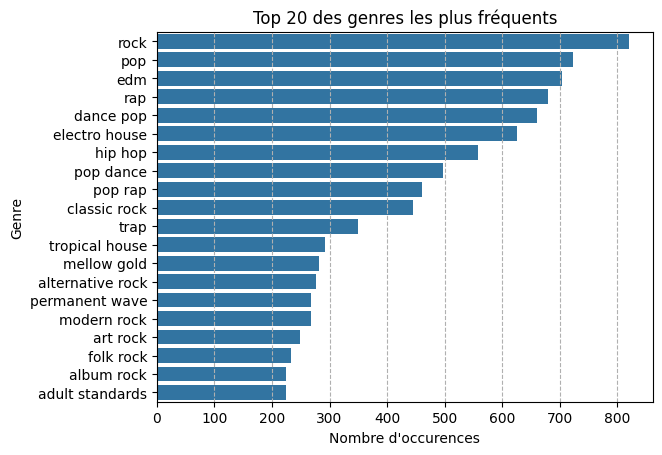

In [13]:
top_genres, top_counts = get_top_genres(df, 20)

sns.barplot(x=top_counts, y=top_genres)
plt.title("Top 20 des genres les plus fréquents")
plt.xlabel("Nombre d'occurences")
plt.ylabel("Genre")
plt.grid(axis='x', linestyle="--")
plt.show()


In [14]:
def reduce_genres(genre_list):
    macro_genres = set()
    
    for g in genre_list:
        g_str = g.lower()
        
        if any(x in g_str for x in ['rock', 'punk', 'metal', 'grunge']):
            macro_genres.add('Rock')
            
        elif any(x in g_str for x in ['rap', 'hip hop', 'trap', 'drill']):
            macro_genres.add('Rap_HipHop')
            
        elif any(x in g_str for x in ['house', 'edm', 'electro', 'techno', 'trance', 'disco', 'dance']):
            macro_genres.add('Electro_Dance')
            
        elif any(x in g_str for x in ['jazz', 'blues', 'soul', 'r&b', 'funk']):
            macro_genres.add('Jazz_Soul')
            
        elif any(x in g_str for x in ['country', 'folk']):
            macro_genres.add('Country_Folk')
            
        elif 'pop' in g_str:
            macro_genres.add('Pop')
            
        elif 'latin' in g_str or 'reggaeton' in g_str:
            macro_genres.add('Latin')
            
        elif 'classical' in g_str:
            macro_genres.add('Classical')
            
    return list(macro_genres)


In [15]:
df["macro_genres"] = df["genres"].apply(reduce_genres)

In [16]:
all_macro_genres = [genre for liste_genres in df['macro_genres'] for genre in liste_genres]

unique_macro_genres = np.unique(all_macro_genres)

print(f"Nombre de macro-genres uniques : {len(unique_macro_genres)}")
print(unique_macro_genres)

Nombre de macro-genres uniques : 8
['Classical' 'Country_Folk' 'Electro_Dance' 'Jazz_Soul' 'Latin' 'Pop'
 'Rap_HipHop' 'Rock']


In [17]:
for genre in unique_macro_genres:
    df[f"genre_{genre}"] = df["macro_genres"].apply(lambda x : 1 if genre in x else 0)


In [18]:
df["year"] = pd.to_datetime(df["release_date"], format="mixed").dt.year
df["explicit"] = df["explicit"].astype(int)

In [19]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=17)

In [20]:
to_exclude = ["id", "artist_name", "track_name", "release_date", "genres", "macro_genres", "popularity"]

X_train = train_set.drop(columns=to_exclude)
y_train = train_set["popularity"]

X_test = test_set.drop(columns=to_exclude)
y_test = test_set["popularity"]

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### **Modèles Vanilla**

#### Random forest 

Nous avons utilisé `RandomizedSearchCV` pour affiner les hyperparamètres de la **Forêt Aléatoire**

In [22]:
random_forest = RandomForestRegressor(
    n_estimators=500, 
    min_samples_split=2, 
    min_samples_leaf=2, 
    max_features="log2", 
    max_depth=None, 
    random_state=17, 
    n_jobs=-1)
    
random_forest.fit(X_train_scaled, y_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
y_pred_random_forest = random_forest.predict(X_test_scaled)

In [24]:
random_forest_results = test_set[["artist_name", "track_name"]].copy()

random_forest_results["real_popularity"] = y_test
random_forest_results["predicted_popularity"] = y_pred_random_forest

random_forest_results["error"] = random_forest_results["real_popularity"] - random_forest_results["predicted_popularity"]

In [25]:
random_forest_results.head()

,artist_name,track_name,real_popularity,predicted_popularity,error
2106,deadmau5,Hyperlandia - Vocal Mix,59,31.024730,27.975270
8361,Betty Boo,Where Are You Baby?,17,38.352217,-21.352217
6274,Lil Tecca,Count Me Out,59,45.891183,13.108817
4327,Fiona Apple,Criminal,0,27.469025,-27.469025
5308,BANNERS,Ghosts,52,43.235894,8.764106


In [26]:
random_forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred_random_forest))
random_forest_mae = mean_absolute_error(y_test, y_pred_random_forest)
random_forest_r2 = r2_score(y_test, y_pred_random_forest)

print("--- Performances du modèle ---")
print(f"RMSE : {random_forest_rmse:.3f}")
print(f"MAE : {random_forest_mae:.3f}")
print(f"R² : {random_forest_r2:.3f}")

--- Performances du modèle ---
RMSE : 22.681
MAE : 19.259
R² : 0.236


In [27]:
if SAVE_RESULTS:
    save_parameters(
        "RandomForestRegressor_vanilla", 
        random_forest.get_params(), 
        random_forest_rmse, 
        random_forest_mae, 
        random_forest_r2, 
        path)

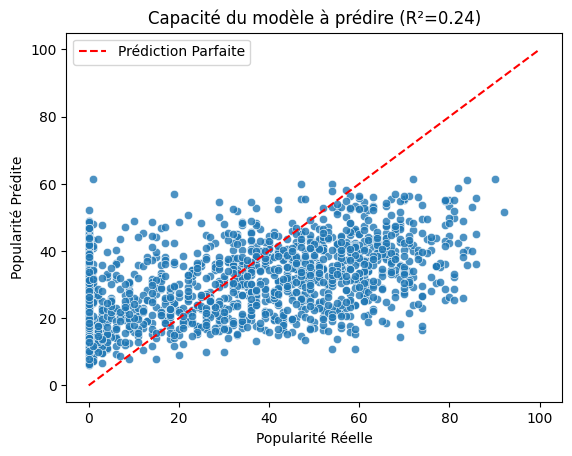

In [28]:
sns.scatterplot(x=y_test, y=y_pred_random_forest, alpha=0.8)
plt.plot([0, 100], [0, 100], "r--", label="Prédiction Parfaite")
plt.xlabel("Popularité Réelle")
plt.ylabel("Popularité Prédite")
plt.title(f"Capacité du modèle à prédire (R²={random_forest_r2:.2f})")
plt.legend()
plt.show()

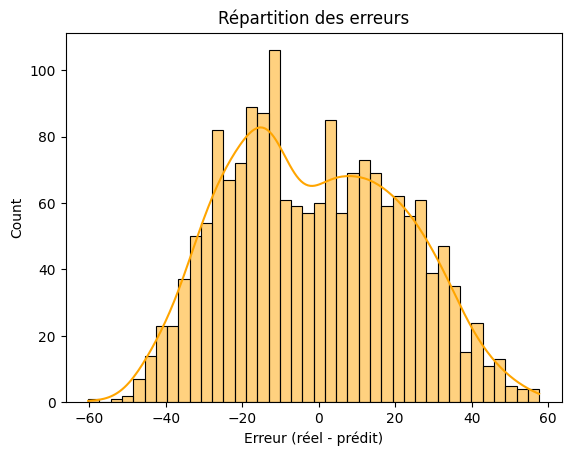

In [29]:
sns.histplot(random_forest_results["error"], bins=40, kde=True, color='orange')
plt.xlabel("Erreur (réel - prédit)")
plt.title("Répartition des erreurs")
plt.show()

#### XGBoost

In [30]:
param_grid_xgb = {
    "n_estimators" : [100, 200, 500, 1000],
    "learning_rate" : [0.01, 0.05, 0.1],
    "max_depth" : [3, 5, 7, 10, 15],
    "subsample" : [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree" : [0.7, 0.8, 0.9],
}

In [31]:
xgb = XGBRegressor(random_state=17, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=50,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=17,
    n_jobs=-1
)

In [ ]:
if SEARCH_BEST_PARAMS:
    print("Recherche des meilleurs paramètres...")
    random_search.fit(X_train_scaled, y_train)
    print(f"\nMeilleurs paramètres trouvés : {random_search.best_params_}")
    xgb_opt = random_search.best_estimator_
else:
    xgb_opt = XGBRegressor(
        subsample=0.7, 
        n_estimators=500, 
        max_depth=7, 
        learning_rate=0.01, 
        colsample_bytree=0.9)
        
    xgb_opt.fit(X_train_scaled, y_train)

In [37]:
y_pred_xgb_opt = xgb_opt.predict(X_test_scaled)

In [38]:
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb_opt))
xgb_mae = mean_absolute_error(y_test, y_pred_xgb_opt)
xgb_r2 = r2_score(y_test, y_pred_xgb_opt)

print(f"RMSE XGBoost : {xgb_rmse:.3f}")
print(f"MAE XGBoost : {xgb_mae:.3f}")
print(f"R² XGBoost : {xgb_r2:.3f}")

RMSE XGBoost : 24.011
MAE XGBoost : 20.296
R² XGBoost : 0.144


In [39]:
if SAVE_RESULTS:
    save_parameters(
        "XGBRegressor_vanilla", 
        random_search.best_params_, 
        xgb_rmse, 
        xgb_mae, 
        xgb_r2, 
        path)

In [40]:
print(f"Gain par rapport à la RF (RMSE {random_forest_rmse:.3f}) : {random_forest_rmse - xgb_rmse:.3f} points")

Gain par rapport à la RF (RMSE 22.681) : -1.330 points


### **Modèles Améliorés**

#### Artist average popularity

Dans le cadre de la popularité d'une musique, l'artiste joue un rôle important.  
Le nombre d'artistes étant trop nombreux pour faire un encodage one-hot, nous allons remplacer le nom de l'artiste par sa **popularité moyenne**. 

In [42]:
artist_means = train_set.groupby("artist_name")["popularity"].mean()
global_mean = train_set["popularity"].mean()

train_set["artist_avg_pop"] = train_set["artist_name"].map(artist_means)
test_set["artist_avg_pop"] = test_set["artist_name"].map(artist_means).fillna(global_mean)

In [43]:
X_train_up_artist = train_set.drop(columns=to_exclude)
y_train_up_artist = train_set["popularity"]

X_test_up_artist = test_set.drop(columns=to_exclude)
y_test_up_artist = test_set["popularity"]

X_train_scaled_up_artist = scaler.fit_transform(X_train_up_artist)
X_test_scaled_up_artist = scaler.fit_transform(X_test_up_artist)

##### Random forest

In [44]:
param_grid_rf = {
    "n_estimators" : [100, 200, 500, 1000],
    "max_features" : ["sqrt", "log2", None],
    "max_depth" : [10, 20, 30, 40, None],
    "min_samples_split" : [2, 4, 5, 6, 10],
    "min_samples_leaf" : [1, 2, 3, 4, 8],
    "bootstrap" : [True, False]
}

In [45]:
random_forest_up_artist = RandomForestRegressor(
    random_state=17, 
    n_jobs=-1)

random_search_rf_up_artist = RandomizedSearchCV(
    estimator=random_forest_up_artist,
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=5,
    random_state=17,
    n_jobs=-1,
    scoring="r2"
)

In [46]:
if SEARCH_BEST_PARAMS:    
    print("Recherche des meilleurs paramètres...")
    random_search_rf_up_artist.fit(X_train_scaled_up_artist, y_train_up_artist)
    print(f"\nMeilleurs paramètres trouvés : {random_search_rf_up_artist.best_params_}")
    random_forest_up_artist = random_search_rf_up_artist.best_estimator_
else:
    random_forest_up_artist = RandomForestRegressor(
        bootstrap=True, 
        ccp_alpha=0.0, 
        criterion="squared_error", 
        max_depth=10, 
        max_features=None,
        max_leaf_nodes=None,
        max_samples=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=4,
        min_samples_split=10,
        min_weight_fraction_leaf=0.0,
        monotonic_cst=None,
        n_estimators=500,
        n_jobs=-1,
        oob_score=False,
        random_state=17,
        verbose=0,
        warm_start=False
        )
        
    random_forest_up_artist.fit(X_train_scaled_up_artist, y_train_up_artist)

In [47]:
y_pred_random_forest_up_artist = random_forest_up_artist.predict(X_test_scaled_up_artist)

In [48]:
random_forest_up_artist_rmse = np.sqrt(mean_squared_error(y_test_up_artist, y_pred_random_forest_up_artist))
random_forest_up_artist_mae = mean_absolute_error(y_test_up_artist, y_pred_random_forest_up_artist)
random_forest_up_artist_r2 = r2_score(y_test_up_artist, y_pred_random_forest_up_artist)

print("--- Performances du modèle ---")
print(f"RMSE : {random_forest_up_artist_rmse:.3f}")
print(f"MAE : {random_forest_up_artist_mae:.3f}")
print(f"R² : {random_forest_up_artist_r2:.3f}")

--- Performances du modèle ---
RMSE : 24.978
MAE : 19.237
R² : 0.073


In [49]:
if SAVE_RESULTS:
    save_parameters(
        "RandomForestRegressor_up_artist", 
        random_forest_up_artist.get_params(), 
        random_forest_up_artist_rmse, 
        random_forest_up_artist_mae, 
        random_forest_up_artist_r2, 
        path)

C'est affreusement pire qu'avant

##### XGBoost

In [50]:
xgb_up_artist = XGBRegressor(random_state=17, n_jobs=-1)

random_search_xgb_up_artist = RandomizedSearchCV(
    estimator=xgb_up_artist,
    param_distributions=param_grid_xgb,
    n_iter=50,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=17,
    n_jobs=-1
)

In [51]:
if SEARCH_BEST_PARAMS:
    print("Recherche des meilleurs paramètres...")
    random_search_xgb_up_artist.fit(X_train_scaled_up_artist, y_train_up_artist)
    print(f"\nMeilleurs paramètres trouvés : {random_search_xgb_up_artist.best_params_}")
    xgb_up_artist = random_search_xgb_up_artist.best_estimator_

else:
    xgb_up_artist = XGBRegressor(
        subsample=1.0,
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        colsample_bytree=0.8
    )

    xgb_up_artist.fit(X_train_scaled_up_artist, y_train_up_artist)

In [53]:
y_pred_xgb_up_artist = xgb_up_artist.predict(X_test_scaled_up_artist)

In [54]:
xgb_up_artist_rmse = np.sqrt(mean_squared_error(y_test_up_artist, y_pred_xgb_up_artist))
xgb_up_artist_mae = mean_absolute_error(y_test_up_artist, y_pred_xgb_up_artist)
xgb_up_artist_r2 = r2_score(y_test_up_artist, y_pred_xgb_up_artist)

print(f"RMSE XGBoost : {xgb_up_artist_rmse:.3f}")
print(f"MAE XGBoost : {xgb_up_artist_mae:.3f}")
print(f"R² XGBoost : {xgb_up_artist_r2:.3f}")

RMSE XGBoost : 24.745
MAE XGBoost : 19.198
R² XGBoost : 0.090


In [55]:
if SAVE_RESULTS:
    save_parameters(
        "XGBRegressor_up_artist",
        random_search_xgb_up_artist.best_params_,
        xgb_up_artist_rmse,
        xgb_up_artist_mae, 
        xgb_up_artist_r2, 
        "models/Exercice2/models_parameters.csv")

C'est affreusement pire qu'avant

#### Genre Average Popularity

La tentative d'améliorer le modèle en utilisant la popularité moyenne d'un artiste étant un échec car beaucoup d'artistes du jeu de test sont inconnus du jeu d'entraînement nous allons exploiter les genres musicaux spécifiques plutôt que les macro-genres.  
1. Calcul de la popularité moyenne
2. Lissage pour éviter que les genres rares aient des scores extrêmes basés sur peu de chansons, on lisse leur moyenne vers la moyenne globale
3. Chaque chanson reçoit un score correspondant à la moyenne des scores de ses genres. 

In [56]:
to_delete = ["macro_genres", "genre_Classical", "genre_Country_Folk", "genre_Electro_Dance", "genre_Jazz_Soul", "genre_Latin", "genre_Pop", "genre_Rap_HipHop", "genre_Rock"]

In [57]:
df_up_genres = df.drop(columns=to_delete)

In [58]:
train_set_up_genres, test_set_up_genres = train_test_split(df_up_genres, test_size=0.2, random_state=17)

In [59]:
global_mean_up_genres = train_set_up_genres["popularity"].mean()

In [60]:
train_set_exploded_up_genres = train_set_up_genres.explode("genres")

genre_stats = train_set_exploded_up_genres.groupby("genres")["popularity"].agg(["mean", "count"])

Pour éviter que les genres sous-représentés ne biaisent le modèle avec des valeurs extrêmes, nous utilisons un lissage. Cette technique pondère la moyenne d'un genre par sa fréquence d'apparition.

**Formule du score lissé :**

$$Score_{genre} = \frac{(Moyenne_{genre} \times N) + (Moyenne_{globale} \times \alpha)}{N + \alpha}$$

Où :
* $N$ : Nombre d'apparitions du genre dans le jeu d'entraînement.
* $\alpha$ (alpha) : Paramètre de lissage (nous avons choisi 10). Plus $\alpha$ est élevé, plus on pousse les genres rares vers la moyenne globale.

In [61]:
smoothing_factor = 10

In [62]:
genre_stats['smoothed_score'] = ((genre_stats['mean'] * genre_stats['count']) + (global_mean * smoothing_factor)) / (genre_stats['count'] + smoothing_factor)
score_dict = genre_stats['smoothed_score'].to_dict()

In [63]:
def get_genre_score(genre_list):
    if not isinstance(genre_list, list) or not genre_list:
        return global_mean

    scores = [score_dict.get(g, global_mean) for g in genre_list]
    
    return np.mean(scores)

In [64]:
train_set_up_genres["genre_score"] = train_set_up_genres["genres"].apply(get_genre_score)
test_set_up_genres["genre_score"] = test_set_up_genres["genres"].apply(get_genre_score)

In [67]:
X_train_up_genres = train_set_up_genres.drop(columns=[c for c in to_exclude if c in train_set_up_genres.columns])
X_train_up_genres = X_train_up_genres.fillna(0)

y_train_up_genres = train_set_up_genres["popularity"]

In [68]:
X_test_up_genres = test_set_up_genres.drop(columns=[c for c in to_exclude if c in test_set_up_genres.columns])
X_test_up_genres = X_test_up_genres.fillna(0)

y_test_up_genres = test_set_up_genres["popularity"]

In [69]:
X_train_scaled_up_genres = scaler.fit_transform(X_train_up_genres)
X_test_scaled_up_genres = scaler.fit_transform(X_test_up_genres)

##### Random forest

In [ ]:
random_forest_up_genres = RandomForestRegressor(
    random_state=17, 
    n_jobs=-1)

random_search_rf_up_genres = RandomizedSearchCV(
    estimator=random_forest_up_genres,
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=5,
    random_state=17,
    n_jobs=-1,
    scoring="r2"
)

In [73]:
if SEARCH_BEST_PARAMS:
    print("Recherche des meilleurs paramètres...")
    random_search_rf_up_genres.fit(X_train_scaled_up_genres, y_train_up_genres)
    print(f"\nMeilleurs paramètres trouvés : {random_search_rf_up_genres.best_params_}")
    random_forest_up_genres = random_search_rf_up_genres.best_estimator_
else:
    random_forest_up_genres = RandomForestRegressor(
        bootstrap=True, 
        ccp_alpha=0.0, 
        criterion="squared_error", 
        max_depth=10, 
        max_features=None,
        max_leaf_nodes=None,
        max_samples=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=2,
        min_samples_split=6,
        min_weight_fraction_leaf=0.0,
        monotonic_cst=None,
        n_estimators=1000,
        n_jobs=-1,
        oob_score=False,
        random_state=17,
        verbose=0,
        warm_start=False
        )
    
    random_forest_up_genres.fit(X_train_scaled_up_genres, y_train_up_genres)

In [74]:
y_pred_random_forest_up_genres = random_forest_up_genres.predict(X_test_scaled_up_genres)

In [77]:
random_forest_up_genres_rmse = np.sqrt(mean_squared_error(y_test_up_genres, y_pred_random_forest_up_genres))
random_forest_up_genres_mae = mean_absolute_error(y_test_up_genres, y_pred_random_forest_up_genres)
random_forest_up_genres_r2 = r2_score(y_test_up_genres, y_pred_random_forest_up_genres)

print("--- Performances du modèle ---")
print(f"RMSE : {random_forest_up_genres_rmse:.3f}")
print(f"MAE : {random_forest_up_genres_mae:.3f}")
print(f"R² : {random_forest_up_genres_r2:.3f}")

--- Performances du modèle ---
RMSE : 22.438
MAE : 18.437
R² : 0.252


In [78]:
if SAVE_RESULTS:
    save_parameters(
        "RandomForestRegressor_up_genres", 
        random_forest_up_genres.get_params(), 
        random_forest_up_genres_rmse, 
        random_forest_up_genres_mae, 
        random_forest_up_genres_r2, 
        path)

##### XGBoost

In [79]:
xgb_up_genres = XGBRegressor(random_state=17, n_jobs=-1)

random_search_xgb_up_genres = RandomizedSearchCV(
    estimator=xgb_up_genres,
    param_distributions=param_grid_xgb,
    n_iter=50,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=17,
    n_jobs=-1
)

In [87]:
if SEARCH_BEST_PARAMS:
    print("Recherche des meilleurs paramètres...")
    random_search_xgb_up_genres.fit(X_train_scaled_up_genres, y_train_up_genres)
    print(f"\nMeilleurs paramètres trouvés : {random_search_xgb_up_genres.best_params_}")
    xgb_up_genres = random_search_xgb_up_genres.best_estimator_
else:
    xgb_up_genres = XGBRegressor(
        subsample=0.7,
        n_estimators=500,
        max_depth=7,
        learning_rate=0.01,
        colsample_bytree=0.9
    )

    xgb_up_genres.fit(X_train_scaled_up_genres, y_train_up_genres)

In [88]:
y_pred_xgb_up_genres = xgb_up_genres.predict(X_test_scaled_up_genres)

In [90]:
xgb_up_genres_rmse = np.sqrt(mean_squared_error(y_test_up_genres, y_pred_xgb_up_genres))
xgb_up_genres_mae = mean_absolute_error(y_test_up_genres, y_pred_xgb_up_genres)
xgb_up_genres_r2 = r2_score(y_test_up_genres, y_pred_xgb_up_genres)

print(f"RMSE : {xgb_up_genres_rmse:.3f}")
print(f"MAE : {xgb_up_genres_mae:.3f}")
print(f"R² : {xgb_up_genres_r2:.3f}")

RMSE : 22.458
MAE : 18.567
R² : 0.251


In [91]:
if SAVE_RESULTS:
    save_parameters(
        "XGBRegressor_up_genres",
        random_search_xgb_up_genres.best_params_,
        xgb_up_genres_rmse,
        xgb_up_genres_mae, 
        xgb_up_genres_r2, 
        "models/Exercice2/models_parameters.csv")

#### Adding genre diversity and age

Nous allons essayer d'améliorer nos prédictions en implémentant de nouvelles features :  

1. **Âge logarithmique (`age_log`)** : Nous transformons l'âge de la chanson ($\ln(age + 1)$) pour compresser les écarts entre les morceaux anciens et mettre l'accent sur les différences de popularité des morceaux récents.
2. **Diversité musicale (`num_genres`)** : Un compteur du nombre de tags associés à chaque titre, un titre ayant beaucoup de genre est susceptible d'être dans plus de playlist.
3. **Double target encoding lissé** : Nous appliquons un score de popularité moyenne pour les **Genres** ET les **Artistes**. Le lissage est utilisé pour stabiliser les prédictions pour les artistes peu fréquents ou absents du jeu d'entraînement.

In [139]:
df_up_diversity = df_up_genres.copy()

In [140]:
df_up_diversity["num_genres"] = df_up_diversity["genres"].apply(len)
df_up_diversity["age"] = 2022 - df_up_diversity["year"]
df_up_diversity["age_log"] = np.log1p(df_up_diversity["age"])

In [141]:
train_set_up_diversity, test_set_up_diversity = train_test_split(df_up_diversity, test_size=0.2, random_state=17)

In [95]:
def get_smoothed_encoding(train, test, column, target, smoothing_factor):
    global_mean = train[target].mean()
    
    if column == 'genres':
        exploded = train.explode(column)
        stats = exploded.groupby(column)[target].agg(['mean', 'count'])
    else:
        stats = train.groupby(column)[target].agg(['mean', 'count'])
    
    smoothed = (stats['mean'] * stats['count'] + global_mean * smoothing_factor) / (stats['count'] + smoothing_factor)
    mapping = smoothed.to_dict()
    
    if column == 'genres':
        def map_list(ls):
            return np.mean([mapping.get(i, global_mean) for i in ls]) if ls else global_mean
        train_out = train[column].apply(map_list)
        test_out = test[column].apply(map_list)
    else:
        train_out = train[column].map(mapping).fillna(global_mean)
        test_out = test[column].map(mapping).fillna(global_mean)
        
    return train_out, test_out

In [142]:
#train_set_up_diversity["artist_score"], test_set_up_diversity["artist_score"] = get_smoothed_encoding(train_set_up_diversity, test_set_up_diversity,"artist_name", "popularity", 20)

In [143]:
train_set_up_diversity["genre_score"], test_set_up_diversity["genre_score"] = get_smoothed_encoding(train_set_up_diversity, test_set_up_diversity, "genres", "popularity", 10)

In [144]:
to_exclude.extend(["age", "year"])

X_train_up_diversity = train_set_up_diversity.drop(columns=[c for c in to_exclude if c in train_set_up_diversity.columns])
X_train_up_disversity = X_train_up_diversity.fillna(0)

y_train_up_diversity = train_set_up_diversity["popularity"]

In [145]:
X_test_up_diversity = test_set_up_diversity.drop(columns=[c for c in to_exclude if c in test_set_up_diversity.columns])
X_test_up_disversity = X_test_up_diversity.fillna(0)

y_test_up_diversity = test_set_up_diversity["popularity"]

In [146]:
X_train_scaled_up_diversity = scaler.fit_transform(X_train_up_diversity)
X_test_scaled_up_diversity = scaler.fit_transform(X_test_up_diversity)

##### Random forest

In [147]:
random_forest_up_diversity = RandomForestRegressor(
    random_state=17, 
    n_jobs=-1)

random_search_rf_up_diversity = RandomizedSearchCV(
    estimator=random_forest_up_diversity,
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=5,
    random_state=17,
    n_jobs=-1,
    scoring="r2"
)

In [157]:
if SEARCH_BEST_PARAMS:
    print("Recherche des meilleurs paramètres...")
    random_search_rf_up_diversity.fit(X_train_scaled_up_diversity, y_train_up_diversity)
    print(f"\nMeilleurs paramètres trouvés : {random_search_rf_up_diversity.best_params_}")
    random_forest_up_diversity = random_search_rf_up_diversity.best_estimator_
else:
    random_forest_up_diversity = RandomForestRegressor(
        bootstrap=True, 
        ccp_alpha=0.0, 
        criterion="squared_error", 
        max_depth=40, 
        max_features="sqrt",
        max_leaf_nodes=None,
        max_samples=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=3,
        min_samples_split=10,
        min_weight_fraction_leaf=0.0,
        monotonic_cst=None,
        n_estimators=1000,
        n_jobs=-1,
        oob_score=False,
        random_state=17,
        verbose=0,
        warm_start=False
        )
    random_forest_up_diversity.fit(X_train_scaled_up_diversity, y_train_up_diversity)

In [158]:
y_pred_random_forest_up_diversity = random_forest_up_diversity.predict(X_test_scaled_up_diversity)

In [178]:
random_forest_up_diversity_rmse = np.sqrt(mean_squared_error(y_test_up_diversity, y_pred_random_forest_up_diversity))
random_forest_up_diversity_mae = mean_absolute_error(y_test_up_diversity, y_pred_random_forest_up_diversity)
random_forest_up_diversity_r2 = r2_score(y_test_up_diversity, y_pred_random_forest_up_diversity)

print("--- Performances du modèle ---")
print(f"RMSE : {random_forest_up_diversity_rmse:.3f}")
print(f"MAE : {random_forest_up_diversity_mae:.3f}")
print(f"R² : {random_forest_up_diversity_r2:.3f}")

--- Performances du modèle ---
RMSE : 22.006
MAE : 18.098
R² : 0.281


In [137]:
if SAVE_RESULTS:
    save_parameters(
        "RandomForestRegressor_up_age_genre", 
        random_forest_up_diversity.get_params(), 
        random_forest_up_diversity_rmse, 
        random_forest_up_diversity_mae, 
        random_forest_up_diversity_r2, 
        path)

Résultats de RandomForestRegressor_up_age_genre enregistrés dans models/Exercice2/models_parameters.csv


##### XGBoost

In [169]:
xgb_up_diversity = XGBRegressor(random_state=17, n_jobs=-1)

random_search_xgb_up_diversity = RandomizedSearchCV(
    estimator=xgb_up_diversity,
    param_distributions=param_grid_xgb,
    n_iter=50,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=17,
    n_jobs=-1
)

In [175]:
if SEARCH_BEST_PARAMS:
    print("Recherche des meilleurs paramètres...")
    random_search_xgb_up_diversity.fit(X_train_scaled_up_diversity, y_train_up_diversity)
    print(f"\nMeilleurs paramètres trouvés : {random_search_xgb_up_diversity.best_params_}")
    xgb_up_diversity = random_search_xgb_up_diversity.best_estimator_
else:
    xgb_up_diversity = XGBRegressor(
        subsample=0.7,
        n_estimators=500,
        max_depth=7,
        learning_rate=0.01,
        colsample_bytree=0.9
    )

    xgb_up_diversity.fit(X_train_scaled_up_diversity, y_train_up_diversity)

In [176]:
y_pred_xgb_up_diversity = xgb_up_diversity.predict(X_test_scaled_up_diversity)

In [177]:
xgb_up_diversity_rmse = np.sqrt(mean_squared_error(y_test_up_diversity, y_pred_xgb_up_diversity))
xgb_up_diversity_mae = mean_absolute_error(y_test_up_diversity, y_pred_xgb_up_diversity)
xgb_up_diversity_r2 = r2_score(y_test_up_diversity, y_pred_xgb_up_diversity)

print(f"RMSE : {xgb_up_diversity_rmse:.3f}")
print(f"MAE : {xgb_up_diversity_mae:.3f}")
print(f"R² : {xgb_up_diversity_r2:.3f}")

RMSE : 22.049
MAE : 17.840
R² : 0.278


In [180]:
if SAVE_RESULTS:
    save_parameters(
        "XGBRegressor_up_diversity_genre_age",
        random_search_xgb_up_diversity.best_params_,
        xgb_up_diversity_rmse,
        xgb_up_diversity_mae, 
        xgb_up_diversity_r2, 
        "models/Exercice2/models_parameters.csv")

### **Modèle Hybride**

/tmp/ipykernel_1596/2139907737.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


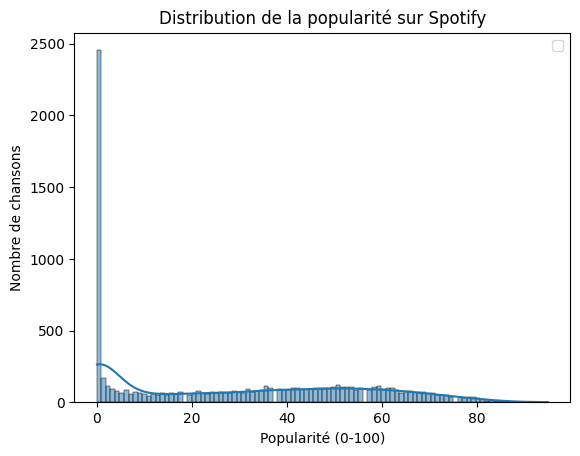

Pourcentage de chansons avec une popularité de 0 : 28.22%


In [262]:
sns.histplot(df['popularity'], bins=100, kde=True)
plt.title('Distribution de la popularité sur Spotify')
plt.xlabel('Popularité (0-100)')
plt.ylabel('Nombre de chansons')
plt.legend()
plt.show()

pct_zero = (df['popularity'] == 0).mean() * 100
print(f"Pourcentage de chansons avec une popularité de 0 : {pct_zero:.2f}%")

L'analyse de la distribution de la variable cible `popularity` révèle une concentration massive de valeurs à **0** (environ 28% du dataset). Cette distribution suggère que le mécanisme de succès d'une chanson suit deux logiques distinctes :
1. **L'existence** : La chanson parvient-elle à générer au moins une écoute/intérêt ?
2. **L'intensité** : Une fois "lancée", quel score de popularité atteint-elle ?

Pour optimiser nos résultats, nous allons tester si modèle hybride peut fonctionner :
* **Étape 1** : Un classifieur binaire (Popularité > 0 ou non).
* **Étape 2** : Un régresseur entraîné uniquement sur les chansons ayant une popularité stictement positive.

In [263]:
df_hybrid = df.copy()

In [264]:
y = df_hybrid["popularity"]
X = df_hybrid.drop(columns=[c for c in to_exclude if c in df_hybrid.columns])
X = X.drop(columns=[c for c in to_delete if c in X.columns])

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [266]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [267]:
y_train_class = (y_train > 0).astype(int)
y_test_class = (y_test > 0).astype(int)

In [268]:
random_forest_classifier = RandomForestClassifier(
    random_state=17, 
    n_jobs=-1
    )

In [269]:
param_grid_clf = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

In [270]:
random_search_clf = RandomizedSearchCV(
    estimator=random_forest_classifier,
    param_distributions=param_grid_clf,
    n_iter=80,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=17
)

In [271]:
SEARCH_BEST_PARAMS = False

In [272]:
if SEARCH_BEST_PARAMS:
    print("Recherche des meilleurs paramètres...")
    random_search_clf.fit(X_train_scaled, y_train_class)
    print(f"\nMeilleurs paramètres trouvés : {random_search_clf.best_params_}")
    random_forest_classifier = random_search_clf.best_estimator_
else:
    random_forest_classifier = RandomForestClassifier(
        n_estimators=500,
        min_samples_split=10,
        min_samples_leaf=2,
        max_depth=10,
        criterion="entropy",
        class_weight="balanced",
        n_jobs=-1,
        random_state=17
    )
    random_forest_classifier.fit(X_train_scaled, y_train_class)

In [273]:
y_pred_class = random_forest_classifier.predict(X_test_scaled)

In [274]:
print("--- PERFORMANCE DU CLASSIFIEUR (FILTRE) ---")
print(f"F1-score : {f1_score(y_test_class, y_pred_class):.3f}")
print("Détail par classe :")
print(classification_report(y_test_class, y_pred_class))

--- PERFORMANCE DU CLASSIFIEUR (FILTRE) ---
F1-score : 0.770
Détail par classe :
              precision    recall  f1-score   support

           0       0.36      0.30      0.33       480
           1       0.75      0.79      0.77      1260

    accuracy                           0.66      1740
   macro avg       0.55      0.55      0.55      1740
weighted avg       0.64      0.66      0.65      1740



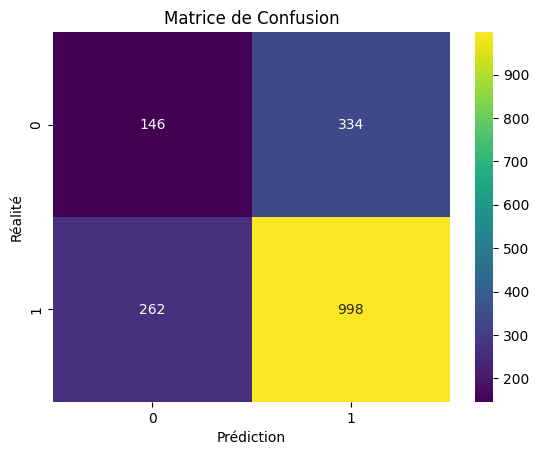

In [275]:
sns.heatmap(confusion_matrix(y_test_class, y_pred_class), annot=True, fmt='d', cmap='viridis')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion')
plt.show()

Le classifieur binaire affiche une performance limitée sur la classe 0 (F1-score de 0.32). 
Cela démontre que les caractéristiques acoustiques ne permettent pas de distinguer 
clairement une chanson à popularité nulle d'une chanson à faible popularité. 

Plutôt que de risquer une cascade d'erreurs avec un filtre imprécis, 
nous optons pour un des modèles précédent.

### **Conclusion : Sélection du Modèle Final**

Après comparaison des performances, nous sélectionnons la **Random Forest** comme modèle final pour les raisons suivantes :

1. **Pouvoir Explicatif ($R^2$)** : Avec un score de **0.2807**, elle explique une part légèrement plus importante de la variance de la popularité que XGBoost.
2. **Gestion des Erreurs Critiques (RMSE)** : Le RMSE de la Random Forest (**22.00**) est inférieur à celui de XGBoost. Comme le RMSE pénalise plus lourdement les grands écarts de prédiction, cela indique que la Random Forest commet des erreurs moins extrêmes.
3. **Stabilité** : Pour ce dataset spécifique, la Random Forest s'est montrée plus robuste face au bruit des variables acoustiques.

Bien que XGBoost affiche une erreur moyenne absolue (MAE) légèrement meilleure, la priorité a été donnée à la réduction des fortes erreurs de prédiction (RMSE).

#### Justification des choix de l'ajout de variables

L'ajout de trois variables cléefa permis d'augmenter légèrement les performances de notre modèle.

1. **Le score de genre (`genre_score`)** : C'est la variable la plus puissante. Elle capture la "hype" historique d'un style. En utilisant les genres spécifiques plutôt que les macros, on permet au modèle de distinguer le potentiel commercial d'une niche par rapport à une autre.
2. **Âge Logarithmique (`age_log`)** : La popularité sur Spotify décline de façon exponentielle avec le temps. Le logarithme permet de linéariser cette relation, rendant la différence entre 1 an et 2 ans plus "visible" pour l'algorithme que la différence entre 40 et 41 ans.
3. **Nombre de Genres (`num_genres`)** : Cette variable agit comme un indicateur de "transversalité". Une chanson multi-taguée a statistiquement plus de chances d'intégrer des playlists variées et donc d'augmenter son score de popularité.

In [284]:
final_results = test_set_up_diversity[["track_name", "artist_name", "year"]].copy()
final_results["Reel"] = y_test_up_diversity
final_results["Predit"] = np.round(y_pred_random_forest_up_diversity, 4)
final_results["Erreur_Absolue"] = np.round(np.abs(final_results["Reel"] - final_results["Predit"]), 4)
final_results.head()

,track_name,artist_name,year,Reel,Predit,Erreur_Absolue
2106,Hyperlandia - Vocal Mix,deadmau5,2021,59,30.2314,28.7686
8361,Where Are You Baby?,Betty Boo,2010,17,28.3830,11.3830
6274,Count Me Out,Lil Tecca,2019,59,57.3415,1.6585
4327,Criminal,Fiona Apple,1996,0,28.6553,28.6553
5308,Ghosts,BANNERS,2016,52,44.3108,7.6892


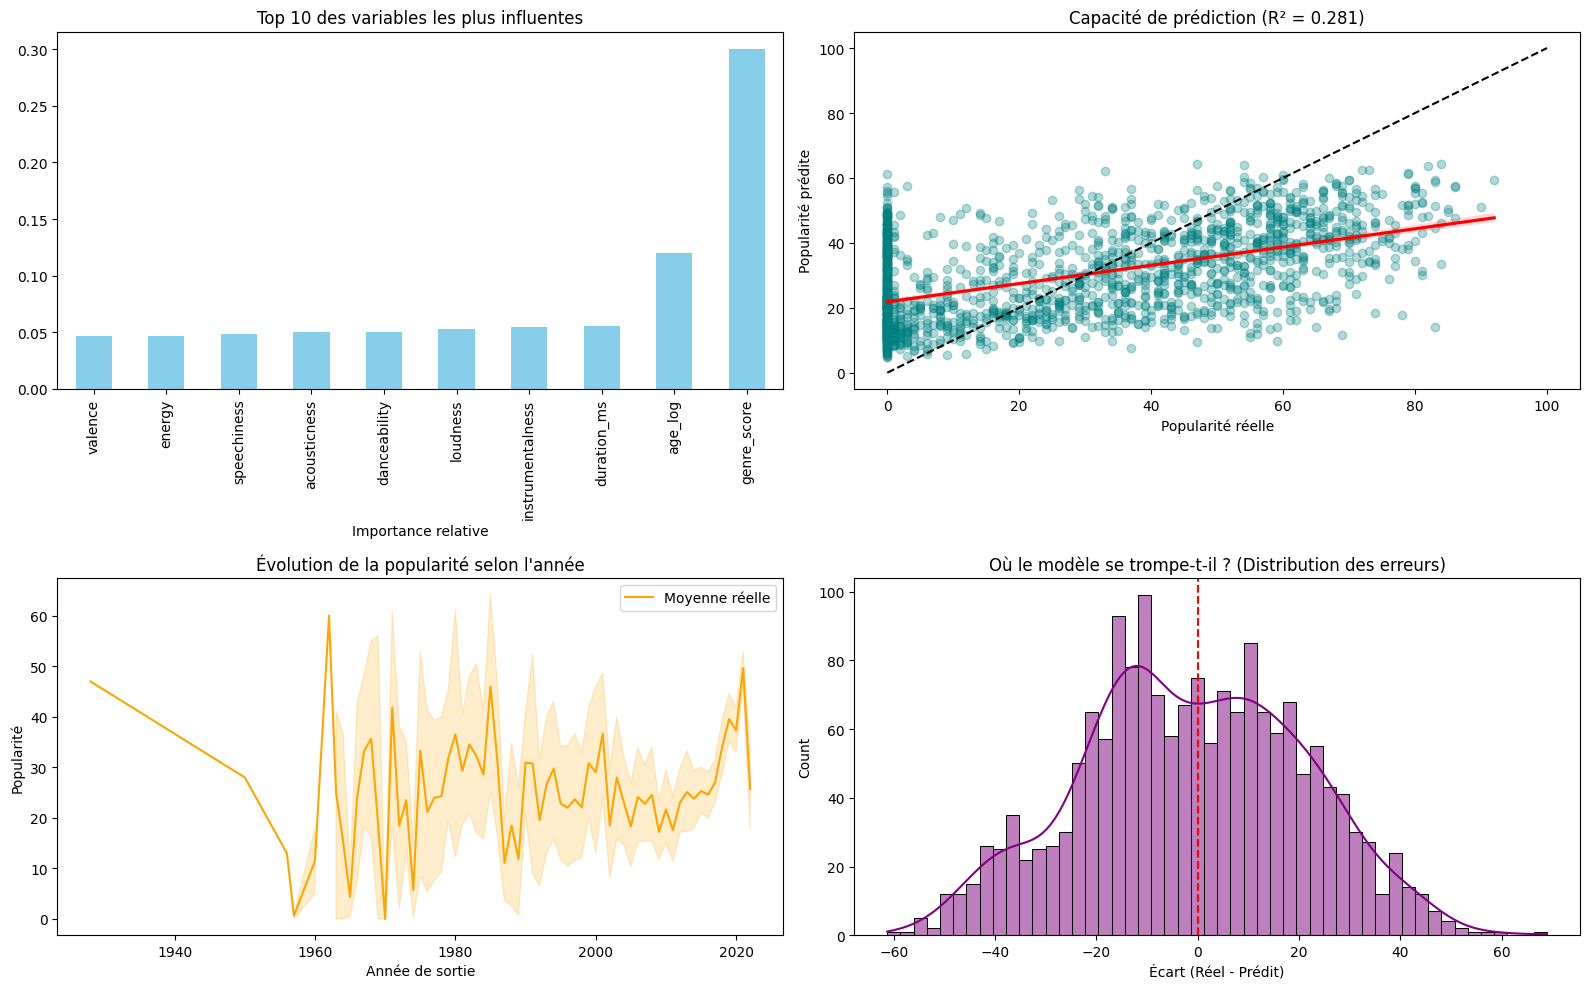

In [287]:
plt.figure(figsize=(16, 10))

# Importance des features
plt.subplot(2, 2, 1)
importances = pd.Series(random_forest_up_diversity.feature_importances_, index=X_train_up_diversity.columns).sort_values(ascending=True)
importances.tail(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 des variables les plus influentes")
plt.xlabel("Importance relative")

# Réel vs Prédit
plt.subplot(2, 2, 2)
sns.regplot(x=y_test_up_diversity, y=y_pred_random_forest_up_diversity, scatter_kws={"alpha":0.3, "color":"teal"}, line_kws={"color":"red"})
plt.plot([0, 100], [0, 100], '--k')
plt.title(f"Capacité de prédiction (R² = {random_forest_up_diversity_r2:.3f})")
plt.xlabel("Popularité réelle")
plt.ylabel("Popularité prédite")

# Impact de l'âge
plt.subplot(2, 2, 3)
sns.lineplot(data=test_set_up_diversity, x="year", y="popularity", color="orange", label="Moyenne réelle")
plt.title("Évolution de la popularité selon l'année")
plt.xlabel("Année de sortie")
plt.ylabel("Popularité")

# Distribution des erreurs (résidu)
plt.subplot(2, 2, 4)
errors = y_test_up_diversity - y_pred_random_forest_up_diversity
sns.histplot(errors, kde=True, color="purple", bins=50)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Où le modèle se trompe-t-il ? (Distribution des erreurs)")
plt.xlabel("Écart (Réel - Prédit)")

plt.tight_layout()
plt.show()